In [51]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


# Configuration
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Préparation des données

## 1. Fonctions de transformation

In [52]:
def rotate_image(image, angle_degrees):
    return tf.image.rot90(
        image, 
        k=int(round(angle_degrees / 90)) % 4
    )

def adjust_pixels(image, brightness_delta, contrast_factor):
    bright_image = tf.image.adjust_brightness(image, brightness_delta)
    adjusted_image = tf.image.adjust_contrast(bright_image, contrast_factor)
    return tf.clip_by_value(adjusted_image, 0.0, 1.0)

def degrade_quality(image, quality_level):
    if quality_level == 1:
        smaller = tf.image.resize(image, [112, 112])
        degraded = tf.image.resize(smaller, [224, 224])
        return degraded
    
    elif quality_level == 2:
        saturated = tf.image.adjust_saturation(image, 2.0)
        return saturated
    
    elif quality_level == 3:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        noisy_img = image + noise
        return tf.clip_by_value(noisy_img, 0.0, 1.0)
    
    return image

## 2. Data augmentation

In [53]:
# Fonction de data augmentation
def data_augmentation(X_train, y_train, BATCH_SIZE=32):
    # Vérifier la forme des données
    print("Forme de X_train:", X_train.shape)
    print("Forme de y_train:", y_train.shape)

    # Trouver les indices des images "bad" et "good"
    bad_indices = np.where(y_train[:, 0] == 0)[0]
    good_indices = np.where(y_train[:, 0] == 1)[0]
    
    X_bad = X_train[bad_indices]
    X_good = X_train[good_indices]

    print(f"Nombre d'images 'bad' avant augmentation: {len(X_bad)}")
    print(f"Nombre d'images 'good' avant augmentation: {len(X_good)}")

    # Définir les transformations
    def rotation_transforms():
        return [
            (lambda img: rotate_image(img, 90), "Rotation 90°"),
            (lambda img: rotate_image(img, 180), "Rotation 180°"),
            (lambda img: rotate_image(img, 270), "Rotation 270°")
        ]

    def pixel_transforms():
        return [
            (lambda img: adjust_pixels(img, 0.2, 1.0), "Plus lumineux"),
            (lambda img: adjust_pixels(img, -0.2, 1.0), "Plus sombre"),
            (lambda img: adjust_pixels(img, 0.0, 1.5), "Plus de contraste"),
            (lambda img: adjust_pixels(img, 0.0, 0.7), "Moins de contraste")
        ]

    def quality_transforms():
        return [
            (lambda img: degrade_quality(img, 1), "Perte de résolution"),
            (lambda img: degrade_quality(img, 2), "Saturation extrême"),
            (lambda img: degrade_quality(img, 3), "Bruit gaussien")
        ]

    def combo_transforms():
        combos = []
        rotations = rotation_transforms()
        pixels = pixel_transforms()
        qualities = quality_transforms()
        
        # Combinaisons rotation + pixel
        for rot in rotations:
            for pix in pixels:
                combos.append((
                    lambda img, r=rot[0], p=pix[0]: p(r(img)), 
                    f"{rot[1]} + {pix[1]}"
                ))
        
        # Combinaisons rotation + qualité
        for rot in rotations:
            for qual in qualities:
                combos.append((
                    lambda img, r=rot[0], q=qual[0]: q(r(img)), 
                    f"{rot[1]} + {qual[1]}"
                ))
        
        return combos

    # Collecter toutes les transformations
    all_transforms = (
        rotation_transforms() + 
        pixel_transforms() + 
        quality_transforms() + 
        combo_transforms()
    )

    # Générer les images augmentées
    X_bad_augmented = []
    y_bad_augmented = []
    
    # Suivre l'utilisation des transformations
    transform_counts = {t[1]: 0 for t in all_transforms}

    # Liste pour stocker les transformations utilisées
    used_transforms = []

    # Générer des augmentations jusqu'à atteindre le nombre d'images 'good'
    np.random.seed(42)
    remaining_count = len(X_good)
    
    while len(X_bad_augmented) < remaining_count:
        # Choisir une image source
        img_source = X_bad[len(X_bad_augmented) % len(X_bad)]
        
        # Créer une liste de transformations disponibles
        available_transforms = [
            t for t in all_transforms 
            if transform_counts[t[1]] < (remaining_count // len(all_transforms) + 1)
        ]
        
        # Réinitialiser si nécessaire
        if not available_transforms:
            transform_counts = {t[1]: 0 for t in all_transforms}
            available_transforms = all_transforms
        
        # Choisir une transformation
        transform, transform_name = random.choice(available_transforms)
        
        # Appliquer la transformation
        transformed_img = transform(img_source)
        
        # Ajouter l'image
        X_bad_augmented.append(transformed_img.numpy())
        y_bad_augmented.append(0)
        
        # Stocker la transformation
        used_transforms.append(transform_name)
        
        # Mettre à jour le compteur
        transform_counts[transform_name] += 1

    # Tronquer pour correspondre exactement au nombre d'images 'good'
    X_bad_augmented = X_bad_augmented[:len(X_good)]
    y_bad_augmented = y_bad_augmented[:len(X_good)]
    used_transforms = used_transforms[:len(X_good)]

    # Convertir en arrays numpy
    X_bad_augmented = np.array(X_bad_augmented)
    y_bad_augmented = np.array(y_bad_augmented).reshape(-1, 1)

    # Combiner avec les images "good"
    X_train_balanced = np.concatenate([X_good, X_bad_augmented])
    y_train_balanced = np.concatenate([
        y_train[good_indices], 
        y_bad_augmented
    ])

    # Mélanger le nouvel ensemble d'entraînement
    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    # Créer un nouveau dataset TensorFlow
    train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
    train_dataset_balanced = train_dataset_balanced.shuffle(buffer_size=len(X_train_balanced)).batch(BATCH_SIZE)

    X_bad_original = X_bad  # Les images "bad" originales
    
    return (X_train_balanced, y_train_balanced, train_dataset_balanced, 
            transform_counts, used_transforms, X_bad_original, X_bad_augmented)

## 3. Chargement et Prétraitement des Images

In [54]:
# Obtenir la liste des noms de fichiers et leurs dossiers d'origine
file_paths = []
folders = []

for class_name in ['bad', 'good']:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(class_dir, img_name))
            folders.append(class_name)

In [55]:
# Chargement des images
print("Chargement des images...")
dataset = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',  # Classification binaire
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extraction des images et labels
all_images = []
all_labels = []
for images, labels in dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X = np.concatenate(all_images, axis=0) / 255.0  # Normalisation 
y = np.concatenate(all_labels, axis=0)

# Affichage des statistiques de base
print(f"Nombre total d'images: {X.shape[0]}")
print(f"Images 'bad' (label 0): {np.sum(y == 0)}")
print(f"Images 'good' (label 1): {np.sum(y == 1)}")

Chargement des images...
Found 1152 files belonging to 2 classes.
Nombre total d'images: 1152
Images 'bad' (label 0): 285
Images 'good' (label 1): 867


2025-03-19 18:06:27.287959: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Mélange et préparation des données

In [56]:
# Mélange des données
indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

# On mélange aussi les chemins de fichiers de la même façon
file_paths = np.array(file_paths)
folders = np.array(folders)
file_paths_shuffled = file_paths[indices]
folders_shuffled = folders[indices]

# Affichage des 10 premiers échantillons après mélange
print("\nPremiers échantillons après mélange:")
print("| N° | Nom de l'image                | Dossier d'origine | Label |")
print("|----|--------------------------------|-------------------|-------|")
for i in range(10):
    img_name = os.path.basename(file_paths_shuffled[i])
    folder = folders_shuffled[i]
    label = int(y_shuffled[i])
    print(f"| {i+1:2d} | {img_name:30s} | {folder:15s} | {label}     |")


Premiers échantillons après mélange:
| N° | Nom de l'image                | Dossier d'origine | Label |
|----|--------------------------------|-------------------|-------|
|  1 | 020_png.rf.bc1d8a583bfdb217fac2f64731e9771e.jpg | bad             | 0     |
|  2 | 196_png.rf.7fe8531648ca4aada3540a77f0ed51f6.jpg | good            | 1     |
|  3 | 009_png.rf.4539849089ddf72abf868f1b866a0d09.jpg | good            | 1     |
|  4 | 006_png.rf.c13a364cc262b36d021c69ab2a8533dc.jpg | bad             | 0     |
|  5 | 010_png.rf.1b22cf6babd655ecd7b71eff26a6310b.jpg | good            | 1     |
|  6 | 010_png.rf.49e214452922e22b40fe37eae05704b0.jpg | bad             | 0     |
|  7 | 032_png.rf.f74158859e091821a14a89d777c86dfa.jpg | good            | 1     |
|  8 | 210_png.rf.2476a4242693cc1c0b22a415c208ff82.jpg | good            | 1     |
|  9 | 307_png.rf.2b348fa19f1025ec590df6a0fecba82e.jpg | good            | 1     |
| 10 | 090_png.rf.7d126610d0db8d47ffec2a9dc9043bae.jpg | good            | 1    

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_29276/4279012029.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y_shuffled[i])


## 6. Division des données

In [57]:
# Division train/validation/test (70/15/15)
X_train, X_temp, y_train, y_temp, paths_train, paths_temp, folders_train, folders_temp = train_test_split(
    X_shuffled, y_shuffled, file_paths_shuffled, folders_shuffled, train_size=0.7, stratify=y_shuffled, random_state=42
)

X_val, X_test, y_val, y_test, paths_val, paths_test, folders_val, folders_test = train_test_split(
    X_temp, y_temp, paths_temp, folders_temp, train_size=0.5, stratify=y_temp, random_state=42
)

## 7. Statistiques des ensembles 

In [58]:
# Statistiques des ensembles
print(f"\nEnsemble d'entraînement: {X_train.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")

print(f"\nEnsemble de validation: {X_val.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_val == 0)} ({np.mean(y_val == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_val == 1)} ({np.mean(y_val == 1)*100:.1f}%)")

print(f"\nEnsemble de test: {X_test.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")


Ensemble d'entraînement: 806 images
  - Bad (0): 199 (24.7%)
  - Good (1): 607 (75.3%)

Ensemble de validation: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)

Ensemble de test: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)


## 8. Création des datasets augmentés et équilibrés

In [59]:
X_train_balanced, y_train_balanced, train_dataset, transform_counts, used_transforms, X_bad, X_bad_augmented = data_augmentation(X_train, y_train.reshape(-1, 1), BATCH_SIZE)

# Les autres datasets restent inchangés
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Mise à jour des statistiques pour le nouvel ensemble d'entraînement
print(f"\nEnsemble d'entraînement après augmentation: {X_train_balanced.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_train_balanced == 0)} ({np.mean(y_train_balanced == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_train_balanced == 1)} ({np.mean(y_train_balanced == 1)*100:.1f}%)")

# Afficher les statistiques des transformations
print("\nUtilisation des transformations:")
for name, count in sorted(transform_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {count} fois")

Forme de X_train: (806, 224, 224, 3)
Forme de y_train: (806, 1)
Nombre d'images 'bad' avant augmentation: 199
Nombre d'images 'good' avant augmentation: 607

Ensemble d'entraînement après augmentation: 1214 images
  - Bad (0): 607 (50.0%)
  - Good (1): 607 (50.0%)

Utilisation des transformations:
Rotation 90°: 20 fois
Rotation 180°: 20 fois
Plus lumineux: 20 fois
Plus de contraste: 20 fois
Saturation extrême: 20 fois
Bruit gaussien: 20 fois
Rotation 90° + Plus lumineux: 20 fois
Rotation 90° + Plus sombre: 20 fois
Rotation 90° + Plus de contraste: 20 fois
Rotation 90° + Moins de contraste: 20 fois
Rotation 180° + Plus sombre: 20 fois
Rotation 180° + Plus de contraste: 20 fois
Rotation 180° + Moins de contraste: 20 fois
Rotation 270° + Plus lumineux: 20 fois
Rotation 270° + Plus sombre: 20 fois
Rotation 270° + Plus de contraste: 20 fois
Rotation 270° + Moins de contraste: 20 fois
Rotation 90° + Perte de résolution: 20 fois
Rotation 90° + Saturation extrême: 20 fois
Rotation 90° + Bruit 

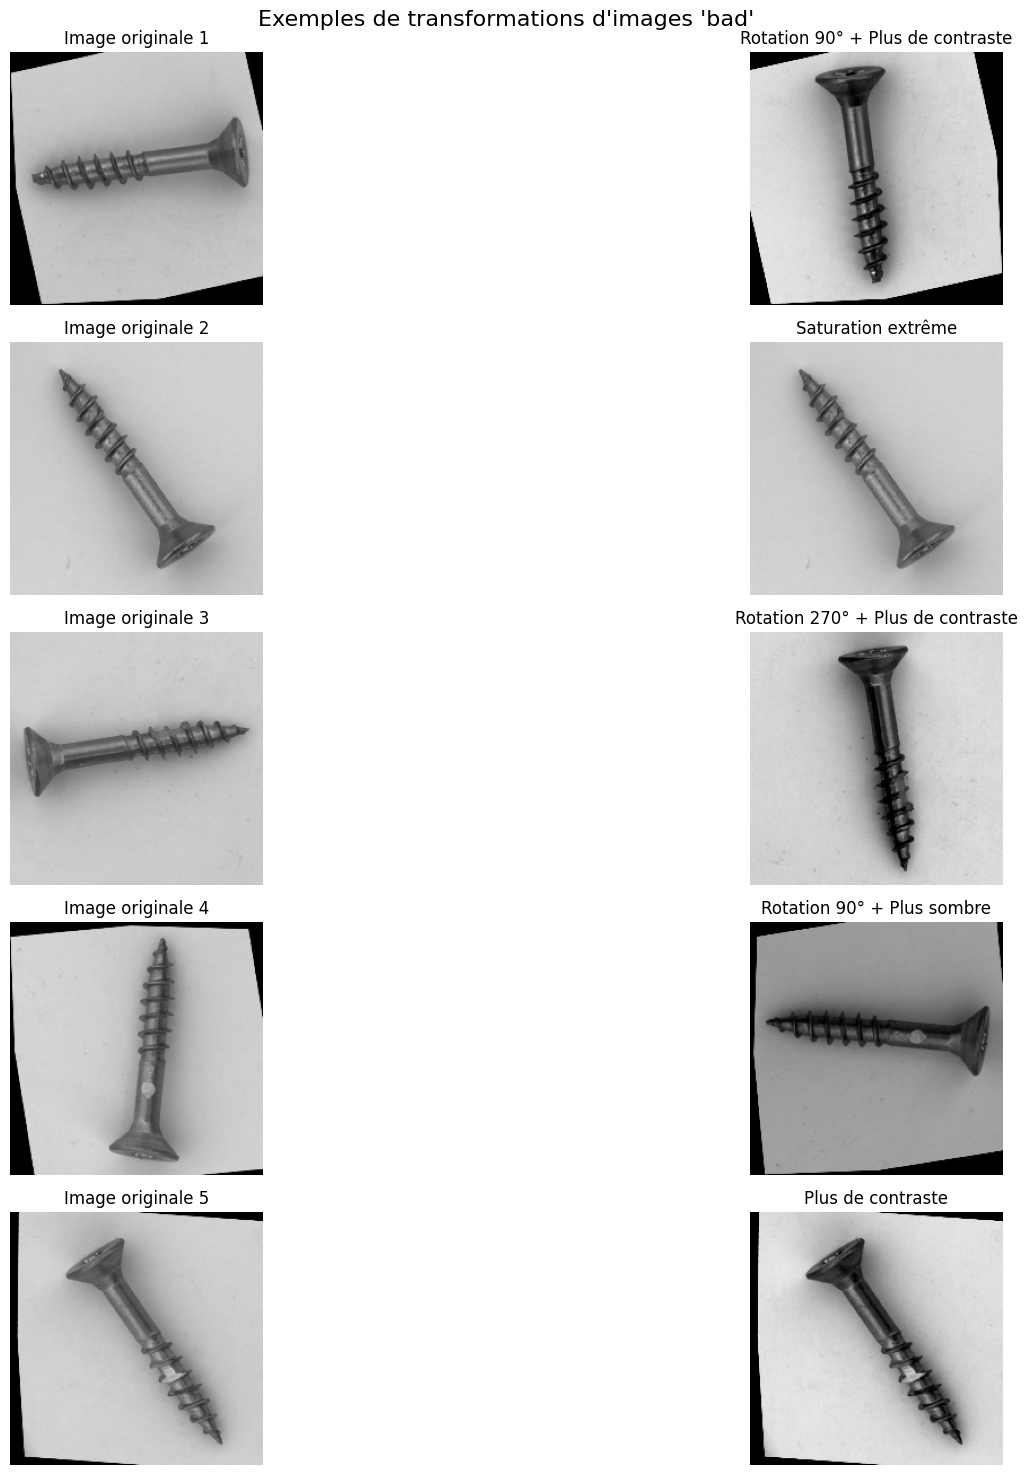

In [60]:
# Visualiser les augmentations
plt.figure(figsize=(20, 15))
visualization_samples = list(zip(X_bad[:5], X_bad_augmented[:5], used_transforms[:5]))

for i, (original, transformed, transform_type) in enumerate(visualization_samples):
    # Image originale
    plt.subplot(5, 2, i*2+1)
    plt.imshow(original)
    plt.title(f"Image originale {i+1}")
    plt.axis('off')
    
    # Image transformée
    plt.subplot(5, 2, i*2+2)
    plt.imshow(transformed)
    plt.title(transform_type)
    plt.axis('off')

plt.suptitle("Exemples de transformations d'images 'bad'", fontsize=16)
plt.tight_layout()
plt.savefig('augmented_bad_images.png')
plt.show()

# Modèle retravaillé

## 1. Définition du modèle CNN retravaillé

### Améliorations principales :

- binary_crossentropy pour la perte

- sigmoid pour la sortie binaire

- Plus de couches convolutives

- Batch Normalization pour stabiliser l'apprentissage

- Dropout pour réduire le surapprentissage

- Métriques supplémentaires (précision, recall, AUC)


(Note : Convolutional Neural Network (CNN), ou réseau de neurones convolutif en français, est une architecture spécifique de réseaux de neurones profonds utilisée en apprentissage automatique et notamment en Deep Learning.)

In [72]:
# Définition du modèle (votre code actuel)
model = models.Sequential([
    # Première couche convolutive avec plus de régularisation
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                 input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # Ajouter dropout dans les couches convolutives
    
    # Deuxième couche convolutive
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),
    
    # Aplatissement et couches denses
    layers.Flatten(),
    layers.Dense(32, activation='relu',  # Réduire la complexité
                kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    layers.Dropout(0.5),
    
    # Couche de sortie
    layers.Dense(1, activation='sigmoid')
])


## 2. Callbacks

In [74]:
# Compilation avec un taux d'apprentissage plus bas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_screw_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

## 3. Entraînement du modèle

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_29276/135989790.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())


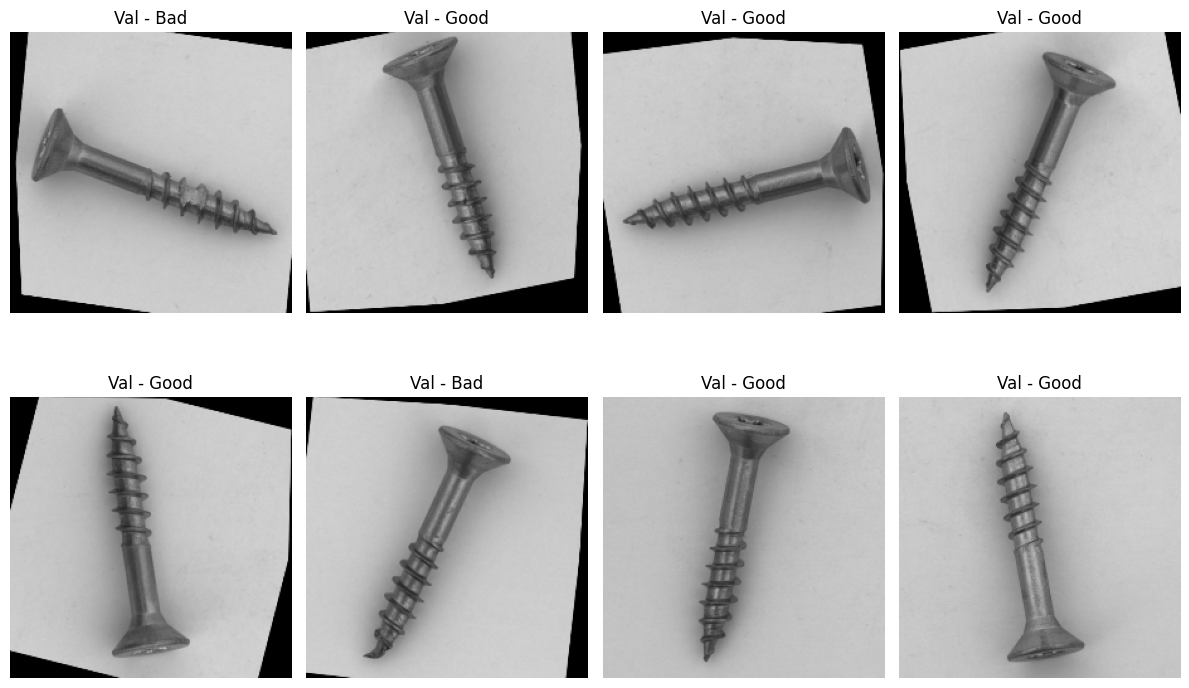

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6947 - loss: 0.7631 - precision: 0.6670 - recall: 0.7732
Epoch 1: val_loss improved from inf to 0.64320, saving model to best_screw_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.6945 - loss: 0.7620 - precision: 0.6669 - recall: 0.7727 - val_accuracy: 0.7514 - val_loss: 0.6432 - val_precision: 0.7514 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7281 - loss: 0.6307 - precision: 0.6663 - recall: 0.8940
Epoch 2: val_loss did not improve from 0.64320
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.7280 - loss: 0.6305 - precision: 0.6667 - recall: 0.8931 - val_accuracy: 0.7514 - val_loss: 0.9643 - val_precision: 0.7514 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7412 - loss: 0.6032 - precision: 0.7221 - recall: 0.8224
Epoch 3: val_loss did not improve from 0.64320
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7410 - loss: 0.6032 - precision: 0.7213 - recall: 0.8230 - val_accuracy: 0.7514 - val_loss: 1.5105 - val_precision: 0.7514 - val_recall: 1.0000 - learn

In [75]:

# Vérifier quelques exemples de l'ensemble de validation
plt.figure(figsize=(12, 8))
images_shown = 0
for images, labels in val_dataset.take(2):  # Prendre 2 batches
    for i in range(min(8, len(images))):
        if images_shown >= 8:
            break
        plt.subplot(2, 4, images_shown+1)
        plt.imshow(images[i])
        label = int(labels[i].numpy())
        plt.title(f"Val - {'Bad' if label==0 else 'Good'}")
        plt.axis('off')
        images_shown += 1
plt.tight_layout()
plt.show()

# Entraînement
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # Assurez-vous que c'est bien val_dataset
    epochs=30,  # Commencer avec moins d'époques
    callbacks=callbacks,
    verbose=1
)

## 4. Évaluation sur l'ensemble de test

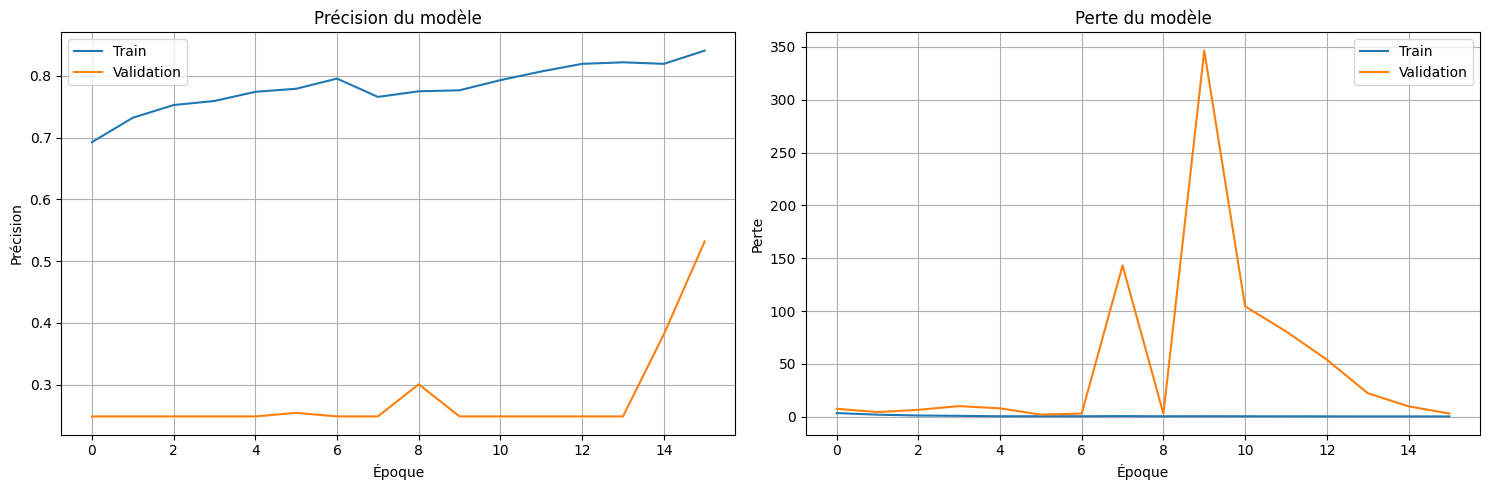

Distribution des valeurs dans y_test_true: (array([0]), array([173]))
Distribution des valeurs dans y_pred: (array([0]), array([173]))
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


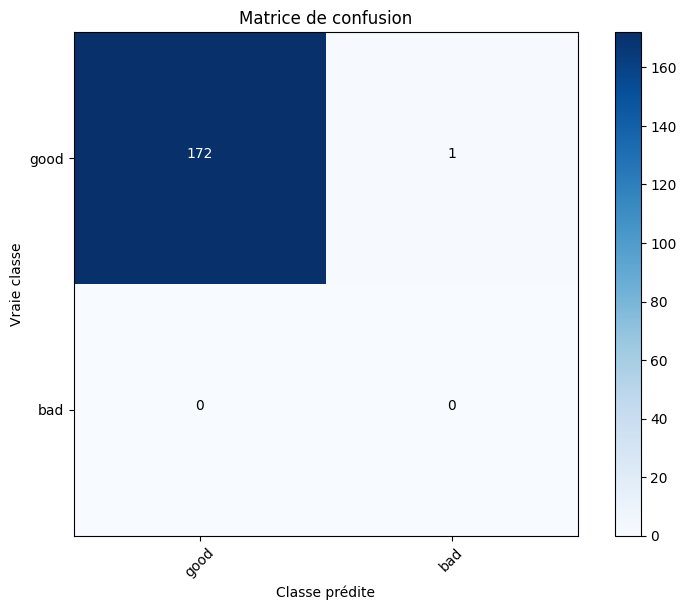

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_29276/4042292416.py:41: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


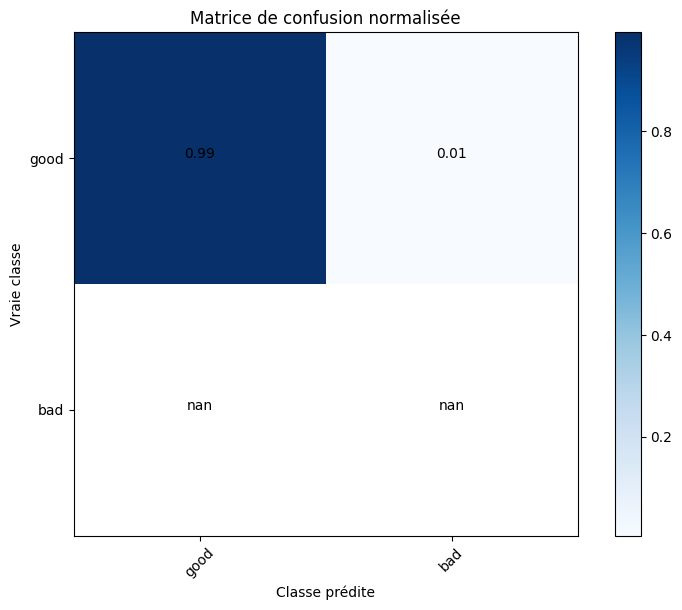


Rapport de classification détaillé :
              precision    recall  f1-score   support

        good       1.00      0.99      1.00       173
         bad       0.00      0.00      0.00         0

    accuracy                           0.99       173
   macro avg       0.50      0.50      0.50       173
weighted avg       1.00      0.99      1.00       173



/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmaco

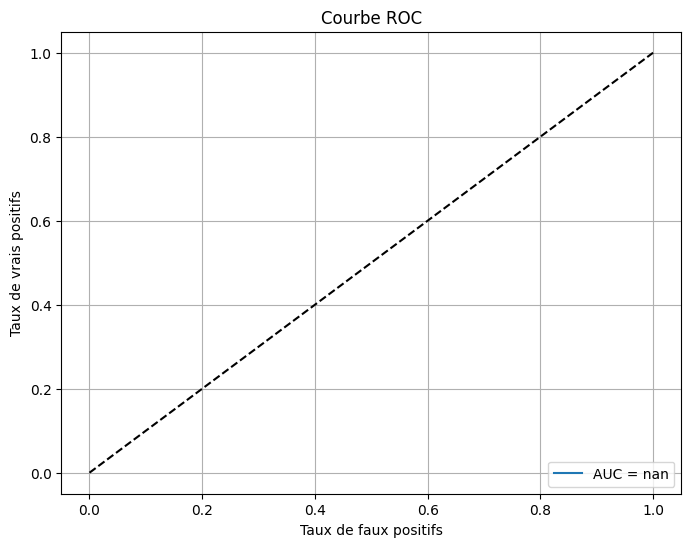

/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


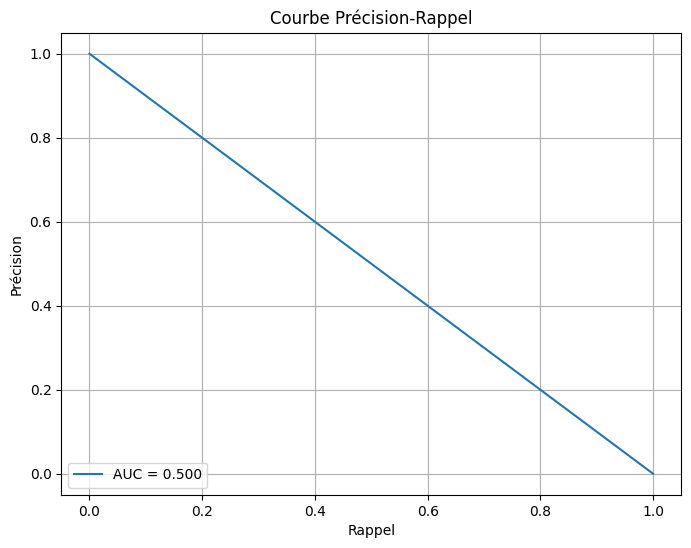

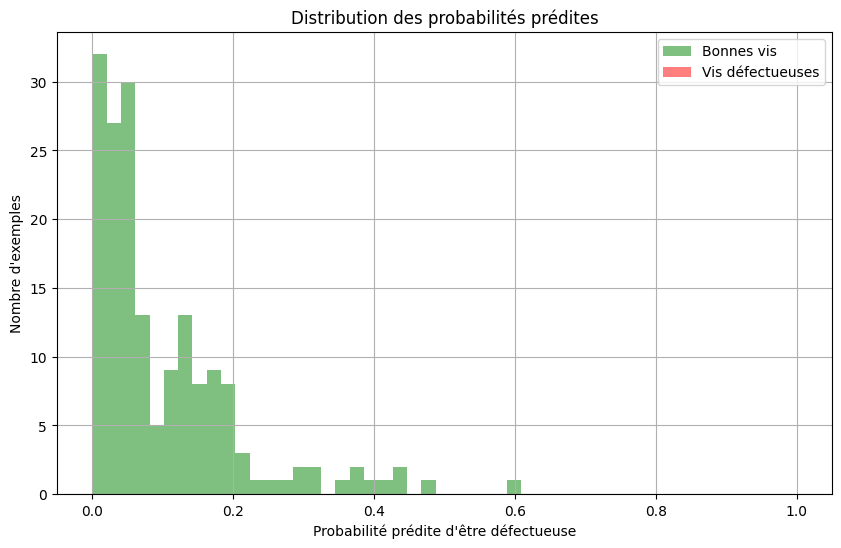

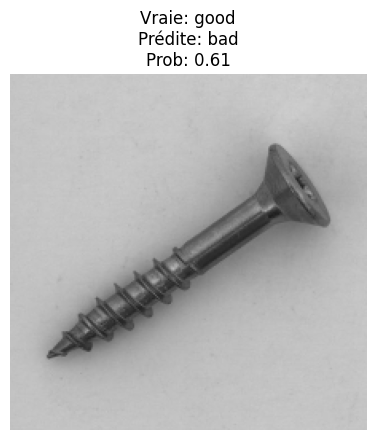


=== DIAGNOSTIC DU MODÈLE ===
Ratio perte validation/entraînement: 8.28
Alerte: Possible surapprentissage (la perte de validation est significativement plus élevée)
Suggestions: Augmenter le dropout, ajouter de la régularisation L2, ou utiliser plus de data augmentation


/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_29276/4042292416.py:182: RuntimeWarning: invalid value encountered in scalar divide
  if cm[0, 0] / np.sum(cm[0, :]) < 0.7 or cm[1, 1] / np.sum(cm[1, :]) < 0.7:


In [67]:
# Après l'entraînement - Visualisations et diagnostics complets
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc

# 1. Courbes d'apprentissage
plt.figure(figsize=(15, 5))

# Graphique de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision du modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Graphique de la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('courbes_apprentissage.png')
plt.show()

# Diagnostic pour vérifier l'ordre des classes
print("Distribution des valeurs dans y_test_true:", np.unique(y_test_true, return_counts=True))
print("Distribution des valeurs dans y_pred:", np.unique(y_pred, return_counts=True))

# 2. Matrice de confusion
def plot_confusion_matrix(cm, classes, normalize=False, title='Matrice de confusion', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    return plt

# Prédictions sur l'ensemble de test
all_x_test = []
all_y_test = []

for batch_x, batch_y in test_dataset:
    all_x_test.append(batch_x)
    all_y_test.append(batch_y)

x_test_combined = np.concatenate(all_x_test, axis=0)
y_test_combined = np.concatenate(all_y_test, axis=0)
y_test_true = np.argmax(y_test_combined, axis=1) if len(y_test_combined.shape) > 1 else y_test_combined

# Prédictions du modèle
y_pred_proba = model.predict(test_dataset)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculer et afficher la matrice de confusion

class_names = ['good', 'bad']  # Assurez-vous que l'ordre correspond à vos indices (0=good, 1=bad)

cm = confusion_matrix(y_test_true, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Matrice de confusion')
plt.savefig('matrice_confusion.png')
plt.show()

# Matrice de confusion normalisée
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Matrice de confusion normalisée')
plt.savefig('matrice_confusion_normalisee.png')
plt.show()

# 3. Rapport de classification détaillé
print("\nRapport de classification détaillé :")
report = classification_report(y_test_true, y_pred, target_names=class_names)
print(report)

# 4. Courbe ROC
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne diagonale de référence
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('courbe_roc.png')
plt.show()

# 5. Courbe Précision-Rappel
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test_true, y_pred_proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'AUC = {pr_auc:.3f}')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('courbe_precision_rappel.png')
plt.show()

# 6. Distribution des probabilités prédites
plt.figure(figsize=(10, 6))
good_scores = y_pred_proba[y_test_true == 0]
bad_scores = y_pred_proba[y_test_true == 1]

plt.hist(good_scores, bins=30, alpha=0.5, label='Bonnes vis', color='green')
plt.hist(bad_scores, bins=30, alpha=0.5, label='Vis défectueuses', color='red')
plt.xlabel('Probabilité prédite d\'être défectueuse')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des probabilités prédites')
plt.legend()
plt.grid(True)
plt.savefig('distribution_probabilites.png')
plt.show()

# 7. Analyse des erreurs - Visualiser quelques exemples mal classés
plt.figure(figsize=(15, 10))

# Identifier les erreurs
misclassified_indices = np.where(y_pred != y_test_true)[0]
num_examples = min(8, len(misclassified_indices))

if num_examples > 0:
    for i, idx in enumerate(misclassified_indices[:num_examples]):
        plt.subplot(2, 4, i+1)
        plt.imshow(x_test_combined[idx])
        true_label = class_names[y_test_true[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"Vraie: {true_label}\nPrédite: {pred_label}\nProb: {y_pred_proba[idx][0]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('erreurs_classification.png')
    plt.show()
else:
    print("Aucune erreur de classification trouvée dans l'ensemble de test!")

# 8. Diagnostic final et recommandations
print("\n=== DIAGNOSTIC DU MODÈLE ===")

# Vérifier s'il y a du surapprentissage
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
loss_ratio = val_loss / train_loss

print(f"Ratio perte validation/entraînement: {loss_ratio:.2f}")
if loss_ratio > 1.3:
    print("Alerte: Possible surapprentissage (la perte de validation est significativement plus élevée)")
    print("Suggestions: Augmenter le dropout, ajouter de la régularisation L2, ou utiliser plus de data augmentation")
elif loss_ratio < 0.8:
    print("Alerte: Comportement inhabituel (la perte de validation est plus basse que celle d'entraînement)")
else:
    print("Le modèle ne montre pas de signes évidents de surapprentissage")

# Analyser le déséquilibre des classes
if cm[0, 0] / np.sum(cm[0, :]) < 0.7 or cm[1, 1] / np.sum(cm[1, :]) < 0.7:
    print("Alerte: Déséquilibre dans les performances entre les classes")
    if cm[0, 1] > cm[1, 0]:
        print("Le modèle a tendance à classifier incorrectement les bonnes vis comme défectueuses")
    else:
        print("Le modèle a tendance à manquer des vis défectueuses (plus risqué)")
    print("Suggestions: Ajuster les poids des classes ou le seuil de décision")

# Recommandations basées sur la distribution des probabilités
if len(good_scores) > 0 and len(bad_scores) > 0:
    mean_good = np.mean(good_scores)
    mean_bad = np.mean(bad_scores)
    
    if abs(mean_good - mean_bad) < 0.3:
        print("Alerte: Distributions de probabilités proches entre les classes")
        print("Le modèle manque peut-être de confiance pour distinguer les classes")
        print("Suggestions: Utiliser des caractéristiques plus discriminantes ou un modèle plus complexe")
    
    # Suggérer un seuil optimal (simpliste)
    optimal_threshold = (mean_good + mean_bad) / 2
    print(f"Seuil de décision suggéré: {optimal_threshold:.2f} (au lieu de 0.5)")